In [2]:
!pip install torch torchvision torchaudio scikit-learn opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 68.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 128.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.2
    Uninstalling numpy-2.3.2:
      Successfully uninstalled numpy-2.3.2━━━━━━ 0/2 [numpy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [opencv-python]0m [opencv-python]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyspark-client 4.0.0 requires googleapis-common-protos>=1.65.0, which is not installed.
pyspark-client 4.0.0 requires grpcio>=1.67.0, which is not installed.
pyspark-client 4.0.0 requires grpcio-status>=1.67.0, which is not installed.
pyspark-client 4.0.0 requires pyarrow>=11.0.0, which is not installed.
pyspark-connect 4.0.0 requires googleapis-common-protos>=1.65.0, which is not installed.
pyspark-conn

/work/Module2Notebooks/Task2
Using cuda device
UNetPP(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0_0): ConvBlock(
    (seq): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv1_0): ConvBlock(
    (seq): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv2_0): ConvBlock(
    (seq): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
  )
  (conv3_0): ConvBlock(
    (seq): Sequen

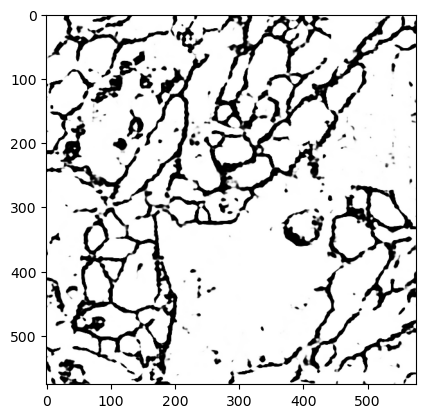

In [1]:
"""
Created on Aug 04 2025

@author: vigo
"""

import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import numpy as np 
import cv2 as cv
import re
import glob

from unetpp import UNetPP

print(os.getcwd())
torch.cuda.empty_cache()

NET_INPUT_SIZE = (576, 576)

def Normalize(img):
    return np.array(img / 255.0, dtype=np.float32)

def Shape_Process(img):
    if img.shape != NET_INPUT_SIZE:
        img = cv.resize(img, NET_INPUT_SIZE, interpolation=cv.INTER_CUBIC)
        
    return img

def Numerical_Sort(value):
    numbers = re.compile(r'(\d+)')
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

def Read_Images_Test(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
        
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis, np.newaxis]
    return images

def Read_Images_Train(folder_path, image_names):
    images = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        img = cv.imread(filename, flags = cv.IMREAD_GRAYSCALE)
        img = Shape_Process(img)
        images.append(Normalize(img))
        
    images = np.asarray(images, dtype=np.float32)
    images = images[:, :, :, np.newaxis]
    return images

def Read_Images_GTruth(folder_path, image_names):
    labels = []
    for filename in sorted(glob.glob(folder_path), key=Numerical_Sort):
        image_names.append(filename.split('/')[-1])
        mask = cv.imread(filename, flags=cv.IMREAD_GRAYSCALE)
        mask = Shape_Process(mask)
        mask = Normalize(mask)
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        labels.append(mask)
        
    labels = np.asarray(labels, dtype=np.float32)
    labels = labels[:, :, :, np.newaxis]
    return labels

def Matplotlib_Imshow(img):
    npimg = img.cpu().detach().numpy()
    npimg = (npimg * 255.0).astype("int")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

drive_path = "./data" 

test_images_path = drive_path + "/test/*.tif"
train_gtruth_path = drive_path + "/train/labels/*.tif"
train_images_path = drive_path + "/train/images/*.tif"

image_names = []
test_images = Read_Images_Test(test_images_path, image_names)
train_images = Read_Images_Train(train_images_path, image_names)    
train_gtruth = Read_Images_GTruth(train_gtruth_path, image_names)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

train_tensor = torch.from_numpy(train_images).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
train_gtruth_tensor = torch.from_numpy(train_gtruth).transpose_(2 , 3).transpose_(1 , 2).float().to(device)
test_tensor = torch.from_numpy(test_images).transpose_(1 , 3).transpose_(2 , 4).float().to(device)

batch_size = 2
train_dl = DataLoader(train_tensor, batch_size=batch_size, shuffle=False)
train_gtruth_dl = DataLoader(train_gtruth_tensor, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_tensor, batch_size = len(test_images), shuffle=False)
test_iter = next(iter(test_dl))

model = UNetPP(in_ch=1, out_ch=1).to(device)
print(model)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)
n_epochs = 300

for e in range(n_epochs):
    for i in range(len(train_dl)):
        train_iter = next(iter(train_dl))
        train_gtruth_iter = next(iter(train_gtruth_dl))
        optim.zero_grad()
        prediction = model(train_iter)
        loss = F.binary_cross_entropy(prediction, train_gtruth_iter)
        loss.backward()
        optim.step()
    print (f'Epoch--[{e+1}/{n_epochs}], Loss: {loss.item()}')

print('Finished Training')

test_img_index = 0
test_prediction = model(test_iter[test_img_index])   

img_grid = make_grid(test_prediction)
Matplotlib_Imshow(img_grid)

torch.save(model.state_dict(), "./model.pth")
print("Saved PyTorch Model State to model.pth")

model_test = UNetPP(in_ch=1, out_ch=1).to(device)
model_test.load_state_dict(torch.load("./model.pth", map_location=device))
model_test.eval()
with torch.no_grad():
    test_prediction = model_test(test_iter[test_img_index])
img_grid = make_grid(test_prediction)
Matplotlib_Imshow(img_grid)

Jaccard(IoU): 0.8362471302350362
F1 Score    : 0.909959061940511
Recall      : 0.9070160547892253
Precision   : 0.913372814655304
Accuracy    : 0.860272479057312


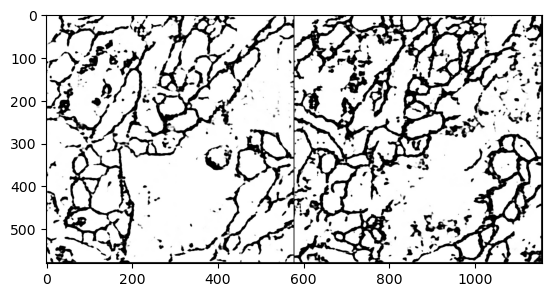

In [2]:
model.eval()
with torch.no_grad():
    p0 = model(test_iter[0])[0]
    p1 = model(test_iter[1])[0]
grid = make_grid(torch.stack([p0, p1], dim=0))
Matplotlib_Imshow(grid)

def batch_metrics(pred, gt, eps=1e-7):
    pred = (pred > 0.5).float()
    gt = (gt > 0.5).float()
    tp = (pred * gt).sum(dim=(1,2,3))
    fp = (pred * (1-gt)).sum(dim=(1,2,3))
    fn = ((1-pred) * gt).sum(dim=(1,2,3))
    tn = ((1-pred) * (1-gt)).sum(dim=(1,2,3))

    iou = (tp / (tp + fp + fn + eps))
    f1  = (2*tp / (2*tp + fp + fn + eps))
    recall = (tp / (tp + fn + eps))
    precision = (tp / (tp + fp + eps))
    acc = ((tp + tn) / (tp + tn + fp + fn + eps))
    return iou, f1, recall, precision, acc

model.eval()
m_iou, m_f1, m_re, m_pr, m_acc = [], [], [], [], []
with torch.no_grad():
    for xb, yb in zip(train_dl, train_gtruth_dl):
        xb = xb.to(device)
        yb = yb.to(device)
        pb = model(xb)
        iou, f1, re, pr, acc = batch_metrics(pb, yb)
        m_iou.append(iou.mean().item())
        m_f1.append(f1.mean().item())
        m_re.append(re.mean().item())
        m_pr.append(pr.mean().item())
        m_acc.append(acc.mean().item())

print("Jaccard(IoU):", sum(m_iou)/len(m_iou))
print("F1 Score    :", sum(m_f1)/len(m_f1))
print("Recall      :", sum(m_re)/len(m_re))
print("Precision   :", sum(m_pr)/len(m_pr))
print("Accuracy    :", sum(m_acc)/len(m_acc))


In [19]:
print(loss.item())

0.0031767685431987047
